### Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача 1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

In [224]:
import pandas as pd

Наши новости

In [225]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [226]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [227]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
#pip install gensim

In [228]:
#предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
# pip install nltk
# nltk.download()  # download stopwords

from razdel import tokenize # https://github.com/natasha/razdel
#pip install razdel

import pymorphy2  
# pip install pymorphy2

In [229]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [230]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [231]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [232]:
news['title']

0        Заместитель председателяnправительства РФnСерг...
1        Матч 1/16 финала Кубка России по футболу был п...
2        Форвард «Авангарда» Томаш Заборский прокоммент...
3        Главный тренер «Кубани» Юрий Красножан прокомм...
4        Решением попечительского совета владивостокско...
                               ...                        
26995    Ученые Токийского университета морских наук и ...
26996    Главой кафедры отечественной истории XX века и...
26997    Американские ученые уточнили возраст расположе...
26998    За последние 50 лет тропический углеродный цик...
26999    У живших примерно 7 тыс. лет назад на территор...
Name: title, Length: 27000, dtype: object

In [233]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 1min 48s


In [234]:
news['title']

0        заместитель председателяnправительства рфnсерг...
1        матч  финала кубка россии по футболу был приос...
2        форвард авангарда томаш заборский прокомментир...
3        главный тренер кубани юрий красножан прокоммен...
4        решением попечительского совета владивостокско...
                               ...                        
26995    ученые токийского университета морских наук и ...
26996    главой кафедры отечественной истории xx века и...
26997    американские ученые уточнили возраст расположе...
26998    за последние  лет тропический углеродный цикл ...
26999    у живших примерно  тыс лет назад на территории...
Name: title, Length: 27000, dtype: object

In [235]:
# %%time
# #Запускаем лемматизацию текста. Будет очень долго...
# news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)
# Wall time: 9min 20s

In [236]:
import pickle
PIK = "news_lemmatization.dat"

# with open(PIK, "wb") as f:
#     pickle.dump(news, f)
with open(PIK, "rb") as f:
    news_lemmatization = pickle.load(f)

In [237]:
news_lemmatization['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [238]:
news['title'] = news_lemmatization['title']

А теперь в 3 строчки обучим нашу модель

In [239]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [240]:
common_dictionary[10]

'ватутин'

In [277]:
# common_corpus

Все просто - это словарь наших слов

Запускаем обучение

In [242]:
from gensim.models import LdaModel

In [243]:
# LdaModel?

In [244]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 4min 59s


In [245]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [246]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.075149335),
 (5, 0.031621438),
 (6, 0.071824245),
 (14, 0.034223292),
 (16, 0.18309215),
 (18, 0.026900096),
 (21, 0.35903504),
 (23, 0.20290579)]

In [247]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: млн год тыс цена погибнуть составить стоимость
topic_1: обнаружить объект суд журнал год который спустя
topic_2: космос городской следствие знаменитый реконструкция лесной ресторан
topic_3: памятник регистрация савченко аппетит разойтись порог хорватия
topic_4: который это россия год также российский страна
topic_5: газ фестиваль производить оплата улица зима метан
topic_6: исследование это риск сша который nn смерть
topic_7: это всё человек свой который ребёнок жизнь
topic_8: земля температура расчёт солнце погода градус небо
topic_9: рейс это норма ресурс экономический отдел связанный
topic_10: фильм выдать вуз стол сын студент ухо
topic_11: военный миссия остров боевой огонь научный территория
topic_12: год это который компания млрд рубль проект
topic_13: человек который это тело город мужчина произойти
topic_14: украина украинский станция киев продукция компания белоруссия
topic_15: экипаж высота км мышь пилот озеро скорость
topic_16: nn фонд год день это который весь
topi

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [248]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [249]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.686850,0.0,0.000000,0.000000,0.000000,...,0.0,0.114901,0.0,0.000000,0.027851,0.0,0.000000,0.0,0.024738,0.0
1,4896,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.265805,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,4897,0.000000,0.0,0.0,0.0,0.071895,0.0,0.066469,0.151804,0.000000,...,0.0,0.133424,0.0,0.026984,0.000000,0.0,0.303780,0.0,0.201717,0.0
3,4898,0.000000,0.0,0.0,0.0,0.000000,0.0,0.160111,0.241164,0.000000,...,0.0,0.102006,0.0,0.000000,0.000000,0.0,0.486541,0.0,0.000000,0.0
4,4899,0.436326,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.027431,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [250]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [251]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [252]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.2123989 ,
       0.        , 0.        , 0.28730682, 0.01754295, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06415407,
       0.        , 0.0930508 , 0.08630265, 0.        , 0.        ,
       0.        , 0.        , 0.05133881, 0.13683511, 0.04135958])

In [253]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, version='Mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if version == 'Mean':
        user_vector = np.mean(user_vector, 0)
    elif version == 'Median':
        user_vector = np.median(user_vector, 0)
    elif version == 'Max':
        user_vector = np.max(user_vector, 0)
    return user_vector

In [254]:
get_user_embedding(user_articles_list, version='Mean')

array([0.        , 0.05774135, 0.01382877, 0.00170793, 0.27141859,
       0.        , 0.07004761, 0.03595893, 0.        , 0.        ,
       0.00944237, 0.02797196, 0.15218148, 0.0078589 , 0.04052526,
       0.        , 0.02051757, 0.01247417, 0.00211432, 0.10812025,
       0.        , 0.02662163, 0.00253989, 0.04172168, 0.08632834])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [255]:
# users['articles'].iloc[33]

In [256]:
# " ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [257]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, version='Mean'), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.002656,0.013142,0.0,0.008043,0.119367,0.000000,0.000000,0.117347,0.002924,...,0.007403,0.046822,0.014384,0.004323,0.026286,0.0,0.009821,0.010696,0.165795,0.059969
1,u108690,0.033784,0.019949,0.0,0.006610,0.253605,0.000000,0.073400,0.082964,0.000000,...,0.000000,0.033698,0.005582,0.000000,0.093629,0.0,0.045385,0.001749,0.003630,0.062996
2,u108339,0.060970,0.045210,0.0,0.000000,0.259766,0.010193,0.036886,0.025326,0.011801,...,0.000000,0.017534,0.000000,0.000000,0.047366,0.0,0.009988,0.002347,0.027037,0.128549


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [258]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [259]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.002656,0.013142,0.0,0.008043,0.119367,0.000000,0.000000,0.117347,0.002924,...,0.046822,0.014384,0.004323,0.026286,0.0,0.009821,0.010696,0.165795,0.059969,0
1,u108690,0.033784,0.019949,0.0,0.006610,0.253605,0.000000,0.073400,0.082964,0.000000,...,0.033698,0.005582,0.000000,0.093629,0.0,0.045385,0.001749,0.003630,0.062996,1
2,u108339,0.060970,0.045210,0.0,0.000000,0.259766,0.010193,0.036886,0.025326,0.011801,...,0.017534,0.000000,0.000000,0.047366,0.0,0.009988,0.002347,0.027037,0.128549,1


In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [261]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [262]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [263]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.17555611, 0.02812035, 0.38072661, 0.24067068, 0.0169776 ,
       0.0309727 , 0.15323846, 0.05921613, 0.03030488, 0.09516369])

In [264]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [265]:
import itertools

In [266]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.233466, F-Score=0.633, Precision=0.552, Recall=0.743


In [267]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1607  148]
 [  64  181]]


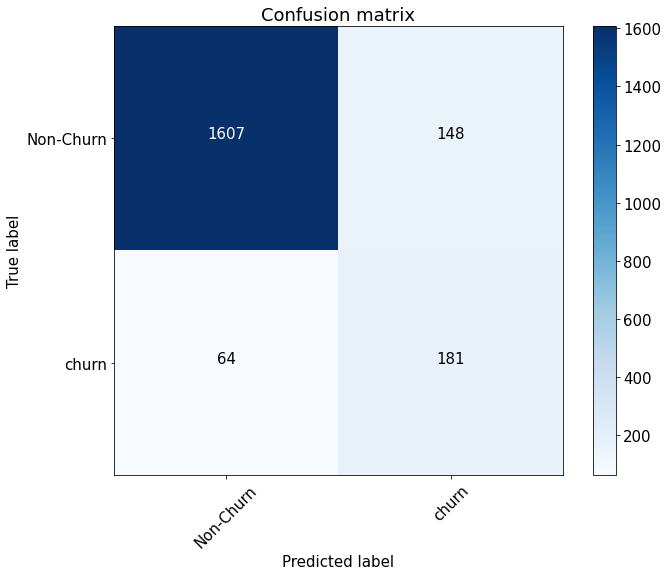

In [268]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [269]:
roc_auc_score(y_test, preds)

0.9353450782022211

In [270]:
table_comp = pd.DataFrame({'user_embeddings': [], 
                           'Threshold': [],
                           'F-Score': [],
                           'Precision': [],
                           'Recall': [],
                           'ROC AUC': []})

In [271]:
table_comp.loc[0] = ['Mean', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

**2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)**

In [272]:
# В функции get_user_embedding считаем медиану
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, version='Median'), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]

X_median = pd.merge(user_embeddings_median, target, 'left')

X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train_median, y_train_median)

#прогнозы для тестовой выборки
preds_median = logreg.predict_proba(X_test_median)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_median, preds_median)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

table_comp.loc[1] = ['Median', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test_median, preds_median)]

**3. Повторить п.2, но используя уже не медиану, а max**

In [273]:
# В функции get_user_embedding считаем максимальное
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, version='Max'), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]

X_max = pd.merge(user_embeddings_max, target, 'left')

X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train_max, y_train_max)

#прогнозы для тестовой выборки
preds_max = logreg.predict_proba(X_test_max)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_max, preds_max)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

table_comp.loc[2] = ['Max', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test_max, preds_max)]

**5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score**

In [274]:
table_comp

,user_embeddings,Threshold,F-Score,Precision,Recall,ROC AUC
0,Mean,0.233466,0.633043,0.551515,0.742857,0.935345
1,Median,0.276031,0.774327,0.785714,0.763265,0.969117
2,Max,0.329317,0.757170,0.712230,0.808163,0.965031


**6. Сделать самостоятельные выводы и предположения о том, почему тот или иной способ оказался эффективнее остальных**

**Ответ:** В нашей задаче, исходя из метрики **f1-score** (0.774) и **roc auc**(0.969), лучше всего отработал алгоритм с расчетом эмбэдинга через медиану. Это связано с тем, что мы отбираем тематики из отсортированного массива, где учитывается половина всего того, что прочитал пользователь. С связи с чем, большее количество тематик, интересные ему, обрабатываются алгоритмом, что позволяет хорошо предсказать, останется ли пользователь на сайте или нет. У отбора через максимальное значение также высокие метрики, потому что, чем чаще встречается тематика, которая интересна пользователю, тем также с большей вероятностью, мы можем предскать его отток.

In [276]:
# 1. Самостоятельно разобраться с тем, что такое tfidf 
# (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 
#  и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

# 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, 
# но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. 
# Не все документы одинаково информативны и несут какой-то положительный сигнал). 
# Подсказка 2 - нужен именно idf, как вес.